# LSTM beta version


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")

#libraries for cleanning
from collections import Counter
pd.options.mode.chained_assignment = None
from collections import defaultdict
from string import punctuation 

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import nltk
nltk.download('stopwords')
df = pd.read_csv('/content/drive/MyDrive/cuatrimestres/Noveno cuatri/Natural Language Preprocessing/Project/data.csv',
            encoding = "ISO-8859-1")
df = df[df['Lang'] == 'en']
df = df.drop(['Lang', 'Date', 'Location','User'], axis = 1) #quitando columnas inecesarias
df



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweet,Label
0,I need paradigm on apple music now ðµâð«...,0
1,ð­hbo go\n\n1 month solo: â±300\n1 month sh...,0
2,I still use my Apple Music just so I can liste...,0
3,Officially switched from Apple Music to Spotif...,0
4,Apple Music so damn irritating bitch where is ...,0
...,...,...
99688,Bought Spotify premium for my family but that ...,1
99689,SPOTIFY DELETED THE PODCAST VERSION OF HITS DI...,1
99690,Also I'm Xylophagous on spotify if anyone on h...,1
99691,Thereâs a very specific version of this song...,1


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re

def scrub_words(text):
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
  
    #remove whitespace
    text=text.strip()
    return text
  
#Noise removal, stop word removal, normalizing?
def cleanString(s, special_chars = "\":,.@|ðÿœžðÿâœœïÿœžÿºÿÿœžÿ"):
    for char in special_chars:
        s = s.replace(char, "")
    s = s.replace("\n", "")
    s = scrub_words(s)
    tokenizer = TweetTokenizer()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
    return " ".join(cleaned_words)

def stemWords(sentence):
    stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
    stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
    return " ".join(stemmed_words)
    
def cleanFrame(frame):
    frame['clean_tweet'] = frame.Tweet.apply(cleanString)

def stemFrame(frame):
    frame['stem_tweet'] = frame.clean_tweet.apply(stemWords)

cleanFrame(df)
stemFrame(df)
df.head()

,Tweet,Label,clean_tweet,stem_tweet
0,I need paradigm on apple music now ðµâð«...,0,I need paradigm apple music µ itunes link let,i need paradigm appl music µ itun link let
1,ð­hbo go\n\n1 month solo: â±300\n1 month sh...,0,hbo go month solo month shared months shared h...,hbo go month solo month share month share hbo ...
2,I still use my Apple Music just so I can liste...,0,I still use Apple Music I listen embarrassing ...,i still use appl music i listen embarrass musi...
3,Officially switched from Apple Music to Spotif...,0,Officially switched Apple Music Spotify idek I...,offici switch appl music spotifi idek i feel
4,Apple Music so damn irritating bitch where is ...,0,Apple Music damn irritating bitch music,appl music damn irrit bitch music


In [ ]:
data = df['stem_tweet']
labels = np.array(df['Label'])

In [ ]:
# Split in training validation and test sets
X_train, X_test, y_train, y_test = test = train_test_split(data, labels,test_size=0.02,
                                                           random_state=1,
                                                           stratify = labels)

In [ ]:
from __future__ import print_function
import numpy as np

from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb



max_features = 2000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('x_test shape:', x_test.shape)
#x_test.shape
print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Loading data...
17464789/17464789 [==============================] - 2s 0us/step
25000 train sequences
25000 test sequences
x_test shape: (25000,)
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [ ]:
#embedding_dim = 40

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

# saving and loading the .h5 model
 
# save model
model.save('Model.h5')
print('Model Saved!')
 
# load model
#savedModel=load_model('Model.h5')
#savedModel.summary()

Train...
Epoch 1/4
782/782 [==============================] - 19s 18ms/step - loss: 0.4459 - accuracy: 0.7871 - val_loss: 0.3638 - val_accuracy: 0.8391
Epoch 2/4
782/782 [==============================] - 14s 17ms/step - loss: 0.3326 - accuracy: 0.8566 - val_loss: 0.3466 - val_accuracy: 0.8460
Epoch 3/4
782/782 [==============================] - 14s 17ms/step - loss: 0.2863 - accuracy: 0.8780 - val_loss: 0.3603 - val_accuracy: 0.8471
Epoch 4/4
782/782 [==============================] - 14s 17ms/step - loss: 0.2520 - accuracy: 0.8964 - val_loss: 0.3589 - val_accuracy: 0.8412
Model Saved!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

class ModelROC:
    def __init__(self, model, X_test, y_test, legend):
        self.model = model
        y_pred = self.getPredictions(X_test)
        fpr, tpr, treshold = roc_curve(y_test, y_pred)
        self.fpr = fpr
        self.tpr = tpr
        self.treshold = treshold
        self.auc = auc(fpr, tpr)
        self.legend = legend
        print("Area under the curve " + self.legend + " " + str(self.auc))
    
    def getPredictions(self, X_test):
        return self.model.predict(X_test)
    
    def plotData(self):
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr, self.tpr, label= self.legend + ' (area = {:.3f})'.format(self.auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        
    def plot(self):
        plt.figure(1)
        self.plotData()
        plt.show()
        
    def plotZoom(self, zoom_x, zoom_y):
        plt.figure(2)
        plt.xlim(zoom_x[0], zoom_x[1])
        plt.ylim(zoom_y[0], zoom_y[1])
        self.plotData()
        plt.show()

k = ModelROC(model, x_test, y_test, 'LSTM model')

782/782 [==============================] - 30s 37ms/step
Area under the curve LSTM model 0.9136476064000001


In [ ]:
k.getPredictions(x_test)

782/782 [==============================] - 28s 35ms/step


array([[5.5419081e-01],
       [9.9999428e-01],
       [9.5385957e-01],
       ...,
       [3.5391722e-04],
       [9.6878866e-03],
       [9.7773874e-01]], dtype=float32)

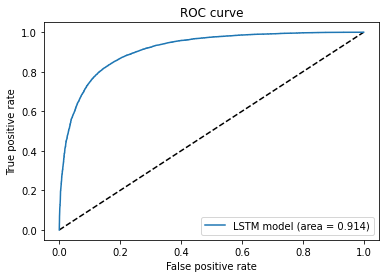

In [ ]:
k.plot()

# BERT CLASSIFICATION

### CLEANING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import nltk
import pandas as pd
nltk.download('stopwords')
df = pd.read_csv('/content/drive/MyDrive/NLP_csv/data.csv',
            encoding = "ISO-8859-1")
df = df[df['Lang'] == 'en']
df = df.drop(['Lang', 'Date', 'Location','User'], axis = 1) #quitando columnas inecesarias

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re


def scrub_words(text):
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
  
    #remove whitespace
    text=text.strip()
    return text
  
#Noise removal, stop word removal, normalizing?
def cleanString(s, special_chars = "\":,.@|ðÿœžðÿâœœïÿœžÿºÿÿœžÿ"):
    for char in special_chars:
        s = s.replace(char, "")
    s = s.replace("\n", "")
    s = scrub_words(s)
    tokenizer = TweetTokenizer()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
    return " ".join(cleaned_words)

def stemWords(sentence):
    stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
    stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
    return " ".join(stemmed_words)
    
def cleanFrame(frame):
    frame['clean_tweet'] = frame.Tweet.apply(cleanString)

def stemFrame(frame):
    frame['stem_tweet'] = frame.clean_tweet.apply(stemWords)

cleanFrame(df)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweet,Label,clean_tweet
0,I need paradigm on apple music now ðµâð«...,0,I need paradigm apple music µ itunes link let
1,ð­hbo go\n\n1 month solo: â±300\n1 month sh...,0,hbo go month solo month shared months shared h...
2,I still use my Apple Music just so I can liste...,0,I still use Apple Music I listen embarrassing ...
3,Officially switched from Apple Music to Spotif...,0,Officially switched Apple Music Spotify idek I...
4,Apple Music so damn irritating bitch where is ...,0,Apple Music damn irritating bitch music


### Balancing Data

In [ ]:
# WE NEED TO GET BALANCED THE PROPORTION OF TWEETS (Apple music / Spotify)
df_1 = df[df['Label'] == 0][0:40000]
df_2 = df[df['Label'] == 1][0:40000]
df = pd.concat([df_1, df_2], axis=0)
print(df[df['Label']==0].value_counts())
print(df[df['Label']==1].value_counts())

Tweet                                                                                                                                                                                                 Label  clean_tweet                                                                                                                              
[DAILY VOTE | 11/22 | #MAMAVOTE #mamamoo] Vote for Mamamoo on the MAMA website and listen to "AYA" on the Apple Music playlist provided by MAMA for at least 30 seconds!                              0      DAILY VOTE MAMAVOTE mamamoo Vote Mamamoo MAMA website listen AYA Apple Music playlist provided MAMA least seconds                            166
[DAILY VOTE | 11/5| #MAMAVOTE | #mamamoo] Moomoos, please remember to vote for Mamamoo on the MAMA website and listen to "AYA" on the Apple Music playlist provided by mama for at least 30 seconds!  0      DAILY VOTE MAMAVOTE mamamoo Moomoos please remember vote Mamamoo MAMA website listen AYA Apple Music p

In [ ]:
# Lets check that both were megered
df.drop(['Tweet'],axis=1)

,Label,clean_tweet
0,0,I need paradigm apple music µ itunes link let
1,0,hbo go month solo month shared months shared h...
2,0,I still use Apple Music I listen embarrassing ...
3,0,Officially switched Apple Music Spotify idek I...
4,0,Apple Music damn irritating bitch music
...,...,...
89688,1,Spotify legally allow Glee Cast eligible show ...
89689,1,Doing Request A Bet top artist year Spotify Wr...
89690,1,spotify wrapped gonna shit im stressed got lis...
89691,1,I think top Artists spotify wrapped r gonna de...


In [ ]:
#LETS SPLIT OUR DATA WITH sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['clean_tweet'],df['Label'], stratify=df['Label'])

#Processor and BERT encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# LETS GIVE ALL THE POWER FOR COMPUTATIONAL PROBLEM with these special layers
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#LETS START THE PROCESSING MODEL based on what tensorflow documentation says.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#THIS IS THE MODEL GENERATED
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text-layer[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
#DESING OF OUR MODEL
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=m)

In [ ]:
# LETS TRAIN OUR MODEL WITH 10 EPOCHS
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 633s 332ms/step - loss: 0.4981 - accuracy: 0.7689 - precision: 0.7641 - recall: 0.7779
Epoch 2/10
1875/1875 [==============================] - 634s 338ms/step - loss: 0.3989 - accuracy: 0.8292 - precision: 0.8239 - recall: 0.8376
Epoch 3/10
1875/1875 [==============================] - 628s 335ms/step - loss: 0.3726 - accuracy: 0.8406 - precision: 0.8367 - recall: 0.8464
Epoch 4/10
1875/1875 [==============================] - 627s 334ms/step - loss: 0.3560 - accuracy: 0.8487 - precision: 0.8451 - recall: 0.8540
Epoch 5/10
1875/1875 [==============================] - 625s 334ms/step - loss: 0.3461 - accuracy: 0.8544 - precision: 0.8512 - recall: 0.8590
Epoch 6/10
1875/1875 [==============================] - 633s 338ms/step - loss: 0.3421 - accuracy: 0.8554 - precision: 0.8517 - recall: 0.8607
Epoch 7/10
1875/1875 [==============================] - 635s 338ms/step - loss: 0.3370 - accuracy: 0.8573 - precision: 0.8544 - recall: 0.8614

In [ ]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 211s 333ms/step - loss: 0.2775 - accuracy: 0.8934 - precision: 0.9189 - recall: 0.8628


[0.27747365832328796,
 0.8933500051498413,
 0.918947696685791,
 0.8628000020980835]

In [ ]:
import numpy as np
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_predicted)
matrix

625/625 [==============================] - 206s 326ms/step


array([[9239,  761],
       [1372, 8628]])

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     10000
           1       0.92      0.86      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



In [ ]:
X_test

50679      If I shackles Drake Spotify wrapped year I know
4386                             Apple Music still supreme
77344               Just blocked loona Spotify streams BBC
31090    So girl shared sex playlist Apple Music babyyy...
84389      u guys think ur number one song spotify wrapped
                               ...                        
59609                I NEED BETTER TOGETHER ON SPOTIFY NOW
14960                                    Apple Music buggy
56802    Fatal Love almost M Get final streams Spotify ...
85779    Vou fingir surpresa quando equal sign estiver ...
38980                    I know Apple Music user I see one
Name: clean_tweet, Length: 20000, dtype: object

In [ ]:
y_predicted

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
test0 = {'tweet':X_test, 'score': y_predicted}
test1 = pd.DataFrame(data=test0)
test1.head(10)

,tweet,score
50679,If I shackles Drake Spotify wrapped year I know,1
4386,Apple Music still supreme,0
77344,Just blocked loona Spotify streams BBC,0
31090,So girl shared sex playlist Apple Music babyyy...,0
84389,u guys think ur number one song spotify wrapped,1
52290,wanna know someone without basic music taste l...,1
87853,Now air Louis Tomlinson amp Bebe Rexha With Di...,0
694,Apple Music replay trash compared Spotify lol ...,0
73196,Where Spotify wrapped like I finna SPAZZ Spotify,1
16532,ine even gotta look apple music summary cause ...,0


In [ ]:
test1.tail(10)

,tweet,score
51146,I wish I Spotify make Kwakupalooza like,1
34749,apple musicone month three months four months ...,0
24389,ask Apple Music playlist want bro lock,0
28519,Dear Apple AppleMusic please add payment metho...,0
79489,year spotify wrapped get WETH,1
59609,I NEED BETTER TOGETHER ON SPOTIFY NOW,1
14960,Apple Music buggy,0
56802,Fatal Love almost M Get final streams Spotify ...,1
85779,Vou fingir surpresa quando equal sign estiver ...,1
38980,I know Apple Music user I see one,0


In [ ]:
model.save('ModelBert.h5')
print('Model Saved!')

Model Saved!
